# Import

In [ ]:
import numpy as np
pi = np.pi
import qiskit.pulse as pulse
import qiskit.pulse.library as pulse_lib
from qiskit.compiler import assemble
from qiskit.pulse.library import Waveform
from qiskit.tools.monitor import job_monitor
from qiskit.pulse import library

import warnings
warnings.filterwarnings('ignore')
from qiskit.tools.jupyter import *
%matplotlib inline

from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

backend_config = backend.configuration()
backend_defaults = backend.defaults()
dt = backend_config.dt

assert backend_config.open_pulse, "Backend doesn't support Pulse"

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

qubit = 0 # qubit we will analyze
default_qubit_freq = backend_defaults.qubit_freq_est[qubit] # Default qubit frequency in Hz. 

# scale data (specific to each device)
scale_factor = 1e-14

# number of shots for our experiments
NUM_SHOTS = 8192

### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)
cont_chan = pulse.ControlChannel(qubit)

def get_job_data(job, average):
    """Retrieve data from a job that has already run.
    Args:
        job (Job): The job whose data you want.
        average (bool): If True, gets the data assuming data is an average.
                        If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data. 
    """
    job_results = job.result() # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average: # get avg data
            result_data.append(job_results.get_memory(i)[qubit]*scale_factor) 
        else: # get single data
            result_data.append(job_results.get_memory(i)[:, qubit]*scale_factor)  
    return result_data

def get_closest_multiple_of_16(num):
    """Compute the nearest multiple of 16. Needed because pulse enabled devices require 
    durations which are multiples of 16 samples.
    """
    return (int(num) - (int(num)%16))

# Drive pulse parameters (us = microseconds)
drive_sigma_us = 0.075                     # This determines the actual width of the gaussian
drive_samples_us = drive_sigma_us*8        # This is a truncating parameter, because gaussians don't have 
                                           # a natural finite length

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating parameter in units of dt

# Find out which measurement map index is needed for this qubit
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

# Get default measurement pulse from instruction schedule map
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])

def apply_sideband(pulse, freq):
    """Apply a sinusoidal sideband to this pulse at frequency freq.
    Args:
        pulse (Waveform): The pulse of interest.
        freq (float): LO frequency for which we want to apply the sweep.
    Return:
        Waveform: Pulse with a sideband applied (oscillates at difference between freq and cal_qubit_freq).
    """
    # time goes from 0 to dt*drive_samples, sine arg of form 2*pi*f*t
    t_samples = np.linspace(0, dt*drive_samples, drive_samples)
    sine_pulse = np.sin(2*np.pi*(f12)*t_samples) # no amp for the sine
    
    # create sample pulse w/ sideband applied
    # Note: need to make sq_pulse.samples real, multiply elementwise
    sideband_pulse = Waveform(np.multiply(np.real(pulse.samples), sine_pulse), name='sideband_pulse')
    
    return sideband_pulse

f01 = default_qubit_freq
f12 = 4.6236*GHz
print(f"Qubit {qubit} has an estimated frequency of {default_qubit_freq/ GHz} GHz.")
print(f"Qubit {qubit} has an anharm frequency of {f12/ GHz} GHz.")

cal_qubit_freq = default_qubit_freq
pi_amp_01 = 0.126
qubit_12_freq = f12
pi_amp_12 = 0.255

#Rx01 ad Rx02 pulses
def rx_pulse_01(theta):
    rxpulse01 = pulse_lib.gaussian(duration=drive_samples,
                                     amp=pi_amp_01*theta/pi, 
                                     sigma=drive_sigma,
                                     name='rx_pulse_01')
    return rxpulse01

def rx_pulse_12(theta):
    rxpulse12 = pulse_lib.gaussian(duration=drive_samples,
                                     amp=pi_amp_12*theta/pi, 
                                     sigma=drive_sigma,
                                     name='rx_pulse_12')
    
    rxpulse_12 = apply_sideband(rxpulse12, qubit_12_freq)
    return rxpulse_12

# Changing phase by applying ShiftPhase once

In [ ]:
t12 = np.radians(33.44)
t23 = np.radians(49.0)
t13 = np.radians(8.57)

f2 = 7.42*10**(-2)
f3 = 2.514

# experimental configuration
timestep = 75 # number of experiments (ie amplitudes to sweep out)

# Drive amplitude values to iterate over: 75 amplitudes evenly spaced from 0 to 1.0
time_min = 0
time_max = 100
times = np.linspace(time_min, time_max, timestep)

# Create schedule
schedules = []

# loop over all drive amplitudes
for ii, time in enumerate(times):
    
    # add commands to schedule
    s = pulse.Schedule(name='Neutrino at t = %s' % time)
    
    #uncomment to start from muon or tau
    #s |= pulse.Play(rx_pulse_01(pi), drive_chan) << s.duration 
    
    #PMNS dagger matrix
    s |= pulse.Play(rx_pulse_12(-2*t23-pi), drive_chan) << s.duration #if start from tau, remove -pi
    s |= pulse.Play(rx_pulse_01(-2*t13), drive_chan) << s.duration 
    s |= pulse.Play(rx_pulse_12(pi), drive_chan) << s.duration
    s |= pulse.Play(rx_pulse_01(-2*t12), drive_chan) << s.duration
    
    #PMNS matrix
    s |= pulse.ShiftPhase((f2)*time, drive_chan) << s.duration #evolution
    s |= pulse.Play(rx_pulse_01(2*t12), drive_chan) << s.duration
    s |= pulse.ShiftPhase((f3)*time, drive_chan) << s.duration #evolution
    s |= pulse.Play(rx_pulse_12(-pi), drive_chan) << s.duration
    s |= pulse.Play(rx_pulse_01(2*t13), drive_chan) << s.duration
    s |= pulse.Play(rx_pulse_12(2*t23+pi), drive_chan) << s.duration
    
    #s |= pulse.Play(rx_pulse_12(pi), drive_chan) << s.duration #unlock BOTH to measure tau
    s |= pulse.Play(rx_pulse_01(pi), drive_chan) << s.duration #unlock to measure muon
    
    s |= measure << s.duration 
                    
    schedules.append(s)
schedules[0].draw()

# Changing phase by "sandwiching"

In [ ]:
t12 = np.radians(33.44)
t23 = np.radians(49.0)
t13 = np.radians(8.57)

f2 = 7.42*10**(-2)
f3 = 2.514

# experimental configuration
timestep = 75 # number of experiments (ie amplitudes to sweep out)

# Drive amplitude values to iterate over: 75 amplitudes evenly spaced from 0 to 1.0
time_min = 0
time_max = 100
times = np.linspace(time_min, time_max, timestep)

# Create schedule
schedules = []

# loop over all drive amplitudes
for ii, time in enumerate(times):
    
    # add commands to schedule
    s = pulse.Schedule(name='Neutrino at t = %s' % time)
    
    #uncomment to start from muon or tau
    #s |= pulse.Play(rx_pulse_01(pi), drive_chan) << s.duration 
    
    #PMNS dagger matrix
    s |= pulse.Play(rx_pulse_12(-2*t23-pi), drive_chan) << s.duration #if start from tau, remove -pi
    s |= pulse.Play(rx_pulse_01(-2*t13), drive_chan) << s.duration 
    s |= pulse.Play(rx_pulse_12(pi), drive_chan) << s.duration
    s |= pulse.Play(rx_pulse_01(-2*t12), drive_chan) << s.duration
    
    #PMNS x evolution matrix
    s |= pulse.ShiftPhase((f2)*time, drive_chan) << s.duration
    s |= pulse.Play(rx_pulse_01(2*t12), drive_chan) << s.duration
    s |= pulse.ShiftPhase((-(f2)*time)%(4*pi), drive_chan) << s.duration
    
    s |= pulse.ShiftPhase((f3)*time, drive_chan) << s.duration
    s |= pulse.Play(rx_pulse_12(-pi), drive_chan) << s.duration
    s |= pulse.ShiftPhase((-(f3)*time)%(4*pi), drive_chan) << s.duration
    
    s |= pulse.ShiftPhase((f2)*time, drive_chan) << s.duration
    s |= pulse.Play(rx_pulse_01(2*t13), drive_chan) << s.duration
    s |= pulse.ShiftPhase((-(f2)*time)%(4*pi), drive_chan) << s.duration
    
    s |= pulse.ShiftPhase((f3)*time, drive_chan) << s.duration
    s |= pulse.Play(rx_pulse_12(2*t23+pi), drive_chan) << s.duration
    s |= pulse.ShiftPhase((-(f3)*time)%(4*pi), drive_chan) << s.duration
    
    #s |= pulse.Play(rx_pulse_12(pi), drive_chan) << s.duration #unlock BOTH to measure tau
    s |= pulse.Play(rx_pulse_01(pi), drive_chan) << s.duration #unlock to measure muon
    
    s |= measure << s.duration 
                    
    schedules.append(s)
schedules[0].draw()

In [ ]:
shot = 8192
program = assemble(schedules,
                   backend=backend,
                   meas_level=2,
                   meas_return='single',
                   shots=shot,
                   schedule_los=[{drive_chan: cal_qubit_freq}] * timestep)

#to measure e/m/t, prepare the schedule and comment the other jobs to only save the corresponding one
test_jobe = backend.run(program)
#test_jobn = backend.run(program)
#test_jobt = backend.run(program)

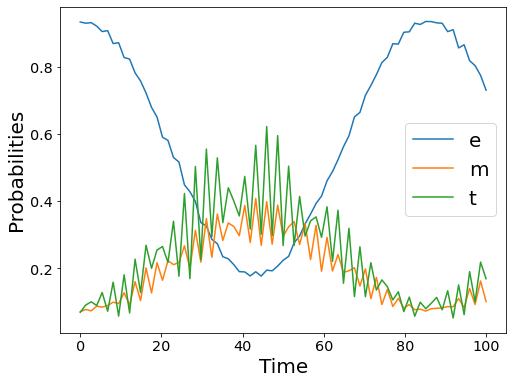

In [16]:
import json
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

shot = 8192
e_survival = []
mu_survival = []
tau_survival = []
tau_survival_trick = []
#a1 = test_jobe.result().get_counts() #if run with IBMQ Job
a1 = json.load( open( "EcountE.json" ) )
for i in a1:
    e_survival.append(i['0']/shot)
#b1 = test_jobn.result().get_counts() #if run with IBMQ Job
b1 = json.load( open( "EcountM.json" ) )
for i in b1:
    mu_survival.append(i['0']/shot)
#c1 = test_jobt.result().get_counts() #if run with IBMQ Job
c1 = json.load( open( "EcountT.json" ) )
for i in c1:
    tau_survival.append(i['0']/shot)
for i,j in zip(e_survival,mu_survival):
    tau_survival_trick.append(1-i-j)
    
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

time = np.linspace(0,100,75)
fig = plt.figure(figsize=(8,6))
plt.plot(time,e_survival,label='e')
plt.plot(time,mu_survival,label='m')
#plt.plot(time,tau_survival_trick,label='t')
plt.plot(time,tau_survival,label='t')
plt.legend(fontsize=20)
plt.xlabel('Time',fontsize=20)
plt.ylabel('Probabilities',fontsize=20)
plt.savefig('StartE.png',dpi=128)
plt.show()